# PC5 - Sélection de modèle et régularisation - 27 juin 2024 - Solution

Dans ce notebook, nous allons utiliser des données simulées pour mieux comprendre les __régularisations L1 et L2__. Ce sera aussi l'occasion de mettre en place une __recherche sur grille__ pour sélectionner le coefficient de régularisation par validation croisée. 

Dans la dernière partie, vous pourrez mettre en œuvre ces algorithmes sur un jeu de données réelles.

Ce notebook sera aussi l'occasion d'aborder un premier algorithme d'apprentissage supervisé _non-linéaire_, la __régression polynomiale__.

Ce notebook a été initialement proposé par [Arthur Imbert](https://github.com/Henley13).

### Import de numpy et matplotlib

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

In [5]:
# On fixe ici la graine pour le générateur de nombres aléatoires, pour faciliter la reproducibilité
np.random.seed(19)

## 1. Régularisation L2 (ridge)

### 1.1 Simulation de données

Commençons par simuler un jeu de données de 30 échantillons avec une seule variable prédictive (p=1) et dans lequel l'étiquette est une fonction non-linéaire (sinusoïdale) de cette variable.

In [6]:
nb_samples = 30

# vrai modèle (Y = true_f(X))
def true_f(x):
    return np.cos(1.5 * np.pi * x) * 5

# tirer nb_samples valeurs de x entre 0 et 1
X = np.random.rand(nb_samples, 1)
y = true_f(X)

# ajouter du bruit
y += np.random.randn(nb_samples, 1) * 0.3
print(X.shape, y.shape)
#Nous pouvons maintenant visualiser ce que nous venons de simuler

(30, 1) (30, 1)


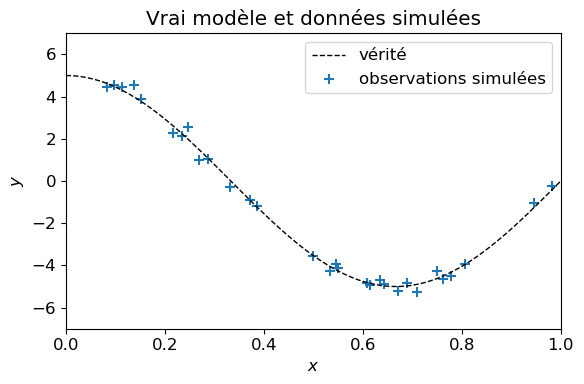

In [7]:
plt.figure(figsize=(6, 4))

# Pour afficher le vrai modèle :
# créer 100 points de vraies paires (x, y) 
# créer un array de dimension (1, 100) contenant 100 valeurs régulièrement espacées entre 0 et 1  
X_grid = np.linspace(0, 1, 100).reshape(-1, 1)
# calculer leurs étiquettes
y_true = true_f(X_grid)
plt.plot(X_grid, y_true, label="vérité", color="black", linewidth=1, linestyle='dashed')

# Afficher les données simulées
plt.scatter(X, y, label="observations simulées", color="tab:blue", marker="+", s=50)

# Mise en forme
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim((0, 1))
plt.ylim((-7, 7))

plt.title("Vrai modèle et données simulées")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Nous pouvons maintenant séparer nos données en un jeu d'entraînement et un jeu de test.

__Question :__ En s'inspirant de la PC4, séparer (`X`, `y`) en un jeu d'entraînement (`X_train`, `y_train`) et un jeu de test (`X_test`, `y_test`). Le jeu de test contiendra 30% des données.

In [6]:
from sklearn import model_selection

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.3, 
                                                                    random_state=4)

__Question :__ Reproduire le graphique précédent, mais distinguer jeu d'entraînement (+) et jeu de test (x) parmi les observations simulées.

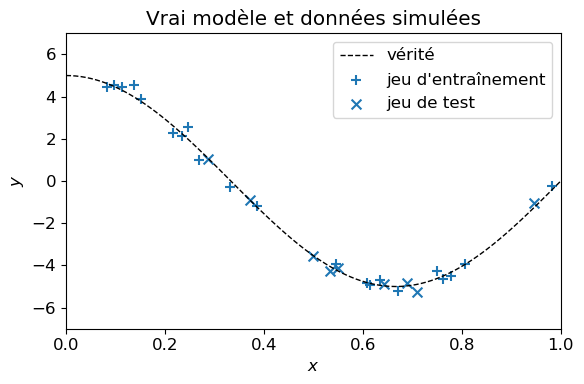

In [8]:
plt.figure(figsize=(6, 4))

# Afficher le vrai modèle
plt.plot(X_grid, y_true, label="vérité", color="black", linewidth=1, linestyle='dashed')

# Afficher les données simulées (entraînement)
plt.scatter(X_train, y_train, label="jeu d'entraînement", c="tab:blue", marker="+", s=50)
# Afficher les données simulées (test)
plt.scatter(X_test, y_test, label="jeu de test", c="tab:blue", marker="x", s=50)

# Mise en forme
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim((0, 1))
plt.ylim((-7, 7))

plt.title("Vrai modèle et données simulées")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### 1.2 Régression linéaire classique

#### Entraînement du modèle

__Question :__ En s'inspirant de la PC4, entraîner une régression linéaire sur `(X_train, y_train)`. Appeler le modèle `linreg`.

Remarquez que les variables ayant été générées centrées-réduites, il n'est pas nécessaire de leur appliquer cette transformation.

In [9]:
from sklearn import linear_model

In [10]:
# Instancier un objet LinearRegression
linreg = linear_model.LinearRegression()

In [11]:
# Entrainer cet objet sur les données d'entraînement
linreg.fit(X_train, y_train)

LinearRegression()

Nous pouvons écrire explicitement le modèle appris en accédant à ses coefficients :

In [12]:
print(f"L'équation du modèle appris est : y = {linreg.coef_[0][0]:.2f} x + {linreg.intercept_[0]:.2f}")

L'équation du modèle appris est : y = -11.62 x + 4.61


#### Performance du modèle

__Question :__ Calculer le [coefficient de détermination](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) de `linreg` sur le jeu d'entraînement et sur le jeu de test.

In [13]:
from sklearn import metrics

In [14]:
linreg_r2_train = metrics.r2_score(y_train, linreg.predict(X_train))
print(f"R2 de la régression linéaire sur le jeu d'entraînement : {linreg_r2_train:.2f}.")

R2 de la régression linéaire sur le jeu d'entraînement : 0.73.


In [15]:
linreg_r2_test = metrics.r2_score(y_test, linreg.predict(X_test))
print(f"R2 de la régression linéaire sur le jeu de test : {linreg_r2_test:.2f}.")

R2 de la régression linéaire sur le jeu de test : -0.45.


__Question :__ Pourquoi comparer ces deux performances ? Qu'en conclure ici ?

__Réponse :__ Si la performance est moins bonne sur le jeu de test, cela indique une situation de sur-apprentissage. Si la performance est mauvaise sur les deux jeux (en particulier celui d'entraînement), cela indique un sous-apprentissage.

Ici, le modèle sous-apprend.

__Remarque :__ La différence entre les performances va dépendre d'où sont situées les observations de chacun des deux jeux.

Par exemple, si tous les points du jeu d'entraînement sont situés entre $x=0,2$ et $x=0,6$, le modèle est bien approché par une droite et la performance sur le jeu d'entraînement sera bonne. Cette droite est une mauvaise approximation de ce qui se passe à l'extérieur de cet intervalle, si le jeu de test contient des points qui s'y trouvent, la performance sera fortement dégradée.

#### Visualisation

__Question :__ Ajouter au graphique précédent le modèle appris.

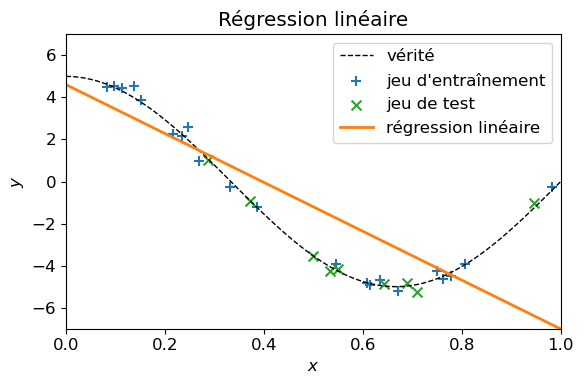

In [16]:
plt.figure(figsize=(6, 4))

# Afficher le vrai modèle
plt.plot(X_grid, y_true, label="vérité", color="black", linewidth=1, linestyle='dashed')

# Afficher les données simulées (entraînement)
plt.scatter(X_train, y_train, label="jeu d'entraînement", color="tab:blue", marker="+", s=50)
# Afficher les données simulées (test)
plt.scatter(X_test, y_test, label="jeu de test", color="tab:green", marker="x", s=50)

# Calculer les prédictions pour les points de X_grid
y_linreg = linreg.predict(X_grid)
# Afficher le modèle corredpondant
plt.plot(X_grid, y_linreg, label="régression linéaire",
         color="tab:orange", linewidth=2)
# (Remarque : on sait ici qu'il s'agit d'une droite donc on pourrait ne calculer que 2 points,
# mais le code proposé ici est générique)

# Mise en forme
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim((0, 1))
plt.ylim((-7, 7))

plt.title("Régression linéaire")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### 1.3 Régression polynomiale 

Nous avons jusqu'à présent travaillé avec une seule variable.

Pour essayer d'améliorer notre modèle, nous pouvons _créer de nouvelles variables_ à partir de celle-ci (par exemple $x^2+x^3$, $\log(x)$, $e^{x-17}$) et apprendre un modèle linéaire sur ces nouvelles variables. Plutôt que de procéder à tatons comme dans les exemples entre parenthèse, on peut se limiter aux _puissances_ de notre variable $x$.

Ainsi, nous allons remplacer l'unique variable $x$ par $d$ variables $x, x^2, x^3, \dots, x^d$. Apprendre une fonction linéaire de ces $d$ variables est équivalent à apprendre un polynôme de degré $d$ de $x$. C'est une première approche pour apprendre un modèle non linéaire !

Cette idée se généralise à un nombre arbitraire de variables initiales ; on crée alors tous les _monomes_ de degré au plus $d$ de ces variables : $(x_1, x_2, \dots, x_p)$ devient $(x_1, x_2, \dots, x_p, x_1^2, x_1 x_2, \dots, x_p^d)$. On parle alors de _régression polynomiale_. Nous en reparlerons dans le chapitre 9. 

Dans scikit-learn, la classe [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) du module `preprocessing` permet de créer ces nouvelles variables, ce que nous allons faire ici pour un degré $d$=15 :

#### Entraînement du modèle

In [13]:
from sklearn import preprocessing

In [18]:
# Instancier un objet permettant de créer des variables polynomiales de degré au plus 15
polynomial_features = preprocessing.PolynomialFeatures(degree=15, include_bias=False)

# Appliquer cet objet aux variables de X_train 
X_train_poly = polynomial_features.fit_transform(X_train)

# Appliquer la même transformation aux données de test
X_test_poly = polynomial_features.transform(X_test)

# Ainsi qu'à la grille de points servant à appliquer le modèle sur tout [0, 1]
X_grid_poly = polynomial_features.transform(X_grid)

print(X_train_poly.shape, X_test_poly.shape, X_grid_poly.shape)

(21, 15) (9, 15) (100, 15)


__Question :__ Combien de variables avons-nous maintenant ?

__Réponse :__ Il y en a 15 : $x^1, x^2, x^3, \dots, x^{15}$

__Question :__ Entraîner maintenant une régression polynomiale `polyreg` sur le jeu d'entraînement.

In [19]:
# Instancier une régression linéaire
polyreg = linear_model.LinearRegression()

# Entrainer cet objet sur les données d'entraînement
polyreg.fit(X_train_poly, y_train)

LinearRegression()

__Question :__ Quelle est maintenant l'équation du modèle appris ?

In [20]:
eqn_str = f"y = {polyreg.intercept_[0]:.1e}"
for degree in range(15):
    coefficient = polyreg.coef_[0][degree]
    if coefficient > 0:
        eqn_str += f" + {coefficient:.1e} x^{degree+1}"
    else : 
        eqn_str += f" - {-coefficient:.1e} x^{degree+1}"
print(eqn_str)

y = 1.9e+02 - 8.2e+03 x^1 + 1.5e+05 x^2 - 1.4e+06 x^3 + 6.1e+06 x^4 - 1.2e+06 x^5 - 1.5e+08 x^6 + 9.5e+08 x^7 - 3.3e+09 x^8 + 7.5e+09 x^9 - 1.2e+10 x^10 + 1.3e+10 x^11 - 9.6e+09 x^12 + 4.6e+09 x^13 - 1.3e+09 x^14 + 1.6e+08 x^15


__Question :__ Que dire de ces coefficients ?

__Réponse :__ Les coefficients ont de très grandes amplitudes, il y a un risque de surapprentissage.

#### Performance du modèle

__Question :__  Calculer le coefficient de détermination de la régression polynomiale sur le jeu d'entraînement et sur le jeu de test.

In [21]:
# Calculer le coefficient de détermination de polyreg sur le jeu d'entraînement
polyreg_r2_train = metrics.r2_score(y_train, polyreg.predict(X_train_poly))
print(f"R2 de la régression polynomiale sur le jeu d'entraînement : {polyreg_r2_train:.2f}.")

# Calculer le coefficient de détermination de polyreg sur le jeu de test
polyreg_r2_test = metrics.r2_score(y_test, polyreg.predict(X_test_poly))
print(f"R2 de la régression polynomiale sur le jeu de test : {polyreg_r2_test:.2f}.")

R2 de la régression polynomiale sur le jeu d'entraînement : 1.00.
R2 de la régression polynomiale sur le jeu de test : -2586.26.


__Question :__ Que pouvez-vous conclure sur le choix de la régression polynomiale ?

__Réponse :__ Le modèle surapprend. Les performances du jeu d'entraînement sont bien supérieures à celles du jeu de test.

#### Visualisation

__Question :__ Remplacer sur le graphique précédent le modèle appris par régression linéaire par celui  appris par régression polynomiale.

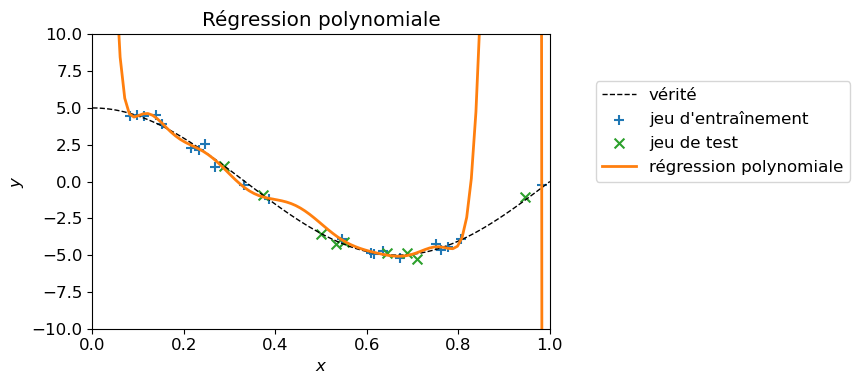

In [22]:
plt.figure(figsize=(9, 4))

# Afficher le vrai modèle
plt.plot(X_grid, y_true, label="vérité", color="black", linewidth=1, linestyle='dashed')

# Afficher les données simulées (entraînement)
plt.scatter(X_train, y_train, label="jeu d'entraînement", color="tab:blue", marker="+", s=50)
# Afficher les données simulées (test)
plt.scatter(X_test, y_test, label="jeu de test", color="tab:green", marker="x", s=50)

# Calculer les prédictions pour les points de X_grid
y_polyreg = polyreg.predict(X_grid_poly)
plt.plot(X_grid, y_polyreg, label="régression polynomiale",
         color="tab:orange", linewidth=2)

# Mise en forme
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim((0, 1))
plt.ylim((-10, 10))

plt.title("Régression polynomiale")
plt.legend(loc=(1.1, 0.5))
plt.tight_layout()
plt.show()

__Question :__ Le graphique est-il cohérent avec les performances calculées ?

__Réponse :__ Oui, la courbe estimée colle complètement aux données d'entraînement, mais pas du tout au vrai modèle. Le modèle appris par régression polynomiale surapprend.

### 1.4 Régression polynomiale régularisée ridge

Comme la régression polynomiale surapprend, nous allons maintenant lui appliquer un terme de __régularisation ridge (L2)__ pour essayer de compenser cet effet :

#### Entraînement du modèle

In [14]:
# Instancier une régression linéaire avec régularisation ridge avec un coefficient de régularisation valant 0.01
polyreg_ridge = linear_model.Ridge(alpha=0.01, random_state=13)

NameError: name 'linear_model' is not defined

__Question :__ Utiliser `polyreg_ridge` pour entraîner une régression polynomiale avec régularisation L2 sur le jeu d'entraînement.

In [24]:
# Entrainer cet objet sur les données d'entraînement
polyreg_ridge.fit(X_train_poly, y_train)

Ridge(alpha=0.01, random_state=13)

__Question :__ Quelle est l'équation de ce modèle ?

In [11]:
eqn_str = f"y = {polyreg_ridge.intercept_[0]:.1e}"
for degree in range(15):
    coefficient = polyreg_ridge.coef_[degree]
    if coefficient > 0.0:
        eqn_str += f" + {coefficient:.1e} x^{degree+1}"
    else : 
        eqn_str += f" - {-coefficient:.1e} x^{degree+1}"
print(eqn_str)

NameError: name 'polyreg_ridge' is not defined

__Question :__ Comparer ces coefficients à ceux du modèle appris sans régularisation.

__Réponse :__ La régularisation a effectivement permis de contrôler l'amplitude des coefficients du modèle.

#### Performance du modèle

__Question :__ Calculer le coefficient de détermination de la régression polynomiale avec régularisation ridge sur le jeu d'entraînement et sur le jeu de test.

In [10]:
# Calculer le coefficient de détermination de polyreg sur le jeu d'entraînement
polyreg_ridge_r2_train = metrics.r2_score(y_train, polyreg_ridge.predict(X_train_poly))
print(f"R2 de la régression polynomiale sur le jeu d'entraînement : {polyreg_ridge_r2_train:.2f}.")

# Calculer le coefficient de détermination de polyreg sur le jeu de test
polyreg_ridge_r2_test = metrics.r2_score(y_test, polyreg_ridge.predict(X_test_poly))
print(f"R2 de la régression polynomiale sur le jeu de test : {polyreg_ridge_r2_test:.2f}.")

NameError: name 'metrics' is not defined

__Question :__ Pensez-vous que le modèle surapprend toujours ?

__Réponse :__ Les performances sont très bonnes sur le jeu d'entraînement comme de test. Il ne semble plus y avoir de surapprentissage.

#### Visualisation

__Question :__ Afficher maintenant ce nouveau modèle.

In [ ]:
plt.figure(figsize=(10, 4))

# Afficher le vrai modèle
plt.plot(X_grid, y_true, label="vérité", color="black", linewidth=1, linestyle='dashed')

# Afficher les données simulées (entraînement)
plt.scatter(X_train, y_train, label="jeu d'entraînement", color="tab:blue", marker="+", s=50)
# Afficher les données simulées (test)
plt.scatter(X_test, y_test, label="jeu de test", color="tab:green", marker="x", s=50)

# Calculer les prédictions pour les points de X_grid
y_polyreg_ridge = polyreg_ridge.predict(X_grid_poly)
plt.plot(X_grid, y_polyreg_ridge, label="régression polynomiale ridge (a=0.01)",
         color="tab:orange", linewidth=2)

# Mise en forme
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim((0, 1))
plt.ylim((-10, 10))

plt.title("Régression polynomiale ridge")
plt.legend(loc=(1.1, 0.5))
plt.tight_layout()
plt.show()

__Question :__ Le graphique est-il cohérent avec les performances calculées ?

__Réponse :__ Oui, la courbe estimée colle bien au modèle, il ne semble pas y avoir de surapprentissage (du moins sur l'intervalle [0, 1]).

__Question :__ Comment aurait-on pu essayer d'éviter le surapprentissage avec une régression polynomiale mais sans régularisation ?

__Réponse :__ En utilisant un degré plus faible que 15.

## 2. Régularisation L1 (Lasso)

### 2.1 Simulation de données

Commençons par simuler un jeu de données de 60 échantillons avec 100 variables, et dans lequel l'étiquette est une fonction linéaire de seulement 10 de ces variables, les autres étant du bruit.

In [ ]:
nb_samples = 60
nb_features = 100

# créer un jeu de données aux dimensions demandées à partir d'une loi normale centrée-réduite
X = np.random.randn(nb_samples, nb_features)

# créer un vecteur de coefficients nuls
beta = np.zeros(nb_features)

# créer des coefficients pour les 10 premières variables
#   (pour faciliter la visualisation,
#   décroissants en valeur absolue, avec alternance de signe)
beta[:10] = [((-1) ** idx * np.exp(-idx/10)) for idx in range(10)]

# créer les étiquettes
y = np.dot(X, beta) + np.random.randn(nb_samples) * 0.1

Visualisons les coefficients du modèle ayant permis de simuler les données :

In [ ]:
plt.figure(figsize=(8, 5))

plt.stem(np.arange(nb_features), beta, markerfmt='o', 
         linefmt='tab:blue',
         label='vrais coefficients')

# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.title("Modèle parcimonieux")
plt.legend(loc="best")
plt.tight_layout()

__Question :__ Séparer (`X`, `y`) en un jeu d'entraînement (`X_train`, `y_train`) et un jeu de test (`X_test`, `y_test`). Le jeu de test contiendra 30% des données.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.3, 
                                                                    random_state=4)

#### Corrélations entre les variables

La difficulté pour l'apprentissage est double :
- seule une faible proportion des variables influencent l'étiquette
- le nombre d'observations est faible par rapport à ce nombre de variables.

Un des problèmes qui apparait quand on a plus de variables que d'observations est que les variables peuvent apparaître corrélées même quand elles ne le sont pas.

__Question :__  En vous inspirant de la PC3, affichez la matrice de corrélation entre les variables.

In [ ]:
# Solution

import pandas as pd

# Calcul de la matrice de corrélation deux à deux
df = pd.DataFrame(X_train)
X_train_corr = df.corr()

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(X_train_corr, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
plt.title("Corrélation entre les variables de X_train")

__Question :__ Commenter cette matrice.

__Réponse :__ On observe des paires de variables assez corrélées (valeur absolue de corrélation > 0.6) alors que les variables ont été tirées indépendantes les unes des autres.

### 2.2 Régression linéaire

__Question :__ Entraîner sur (`X_train, y_train`) une régression linéaire classique. 

In [16]:
# Instancier un objet LinearRegression
linreg = linear_model.LinearRegression()

# Entrainer cet objet sur les données d'entraînement
linreg.fit(X_train, y_train)

NameError: name 'linear_model' is not defined

__Question :__ Évaluer la RMSE de cette régression linéaire sur le jeu d'entraînement et sur le jeu de test. La régression linéaire a-t-elle une performance satisfaisante ? Y-a-t'il un risque de sur- ou de sous-apprentissage ?

In [ ]:
linreg_rmse_train = metrics.root_mean_squared_error(y_train, linreg.predict(X_train))
print(f"RMSE de la régression linéaire sur le jeu d'entraînement : {linreg_rmse_train:.2f}.")

linreg_rmse_test = metrics.root_mean_squared_error(y_test, linreg.predict(X_test))
print(f"RMSE de la régression linéaire sur le jeu de test : {linreg_rmse_test:.2f}.")

__Réponse :__ Il y a manifestement surapprentissage, la performance sur le jeu d'entraînement étant parfaite mais pas sur le jeu de test.

__Question :__ La performance sur le jeu d'entraînement est-elle surprenante ?

__Réponse :__ Comme il y a plus de variables que d'observations, apprendre une régression linéaire est équivalent à résoudre un système linéaire avec plus d'inconnues que d'équations : on peut toujours trouver une solution (il y en a une infinité), et donc avoir une erreur nulle sur le jeu d'entraînement.

Parmi cette infinité de solutions, l'algorithme utilisé pour implémenter la méthode `fit` de `LinearRegression` en trouve une, dont il n'y a aucun moyen de garantir la performance sur le jeu de test.

__Question :__ Ajouter à la visualisation des poids du modèle les coefficients appris par la régression linéaire.

In [ ]:
plt.figure(figsize=(8, 5))

plt.stem(np.arange(nb_features), beta, markerfmt='o', 
         linefmt='tab:blue',
         label='vrais coefficients')

plt.stem(np.arange(nb_features), linreg.coef_, markerfmt='x', 
         linefmt='tab:orange',
         label='coefficients de la régression linéaire')


# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.title("Modèle parcimonieux")
plt.legend(loc="best")
plt.tight_layout()

__Question :__ Comparer les coefficients appris aux vrais coefficients.

__Réponse :__ Les poids appris pour les variables ayant des coefficients non nuls sont plus faibles que les vrais poids. Par contre, les variables qui ne devraient pas entrer dans le modèle ont des poids non nuls, parfois supérieurs (en valeur absolue) à ceux des «vraies» variables. 

La régression linéaire a «réparti» les coefficients sur toutes les variables. 

### 2.3 Lasso

__Question :__ Entrainez un Lasso avec comme paramètre de régularisation `alpha=0.01` sur les données d'entraînement en utilisant la classe [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)  du module `linear_model`.

In [ ]:
# Instancier un objet LinearRegression
lasso = linear_model.Lasso(alpha=0.01, random_state=13)

# Entrainer cet objet sur les données d'entraînement
lasso.fit(X_train, y_train)

__Question :__ Évaluer la RMSE de ce lasso sur le jeu d'entraînement et sur le jeu de test. Y-a-t'il a un risque de sur- ou de sous-apprentissage ?

In [ ]:
lasso_rmse_train = metrics.root_mean_squared_error(y_train, lasso.predict(X_train))
print(f"RMSE du lasso sur le jeu d'entraînement : {lasso_rmse_train:.2f}.")

lasso_rmse_test = metrics.root_mean_squared_error(y_test, lasso.predict(X_test))
print(f"RMSE du lasso sur le jeu de test : {lasso_rmse_test:.2f}.")

__Réponse :__ Il semble toujours y avoir du surapprentissage, mais moins que précédemment.

__Réponse :__ Comme il y a plus de variables que d'observations, apprendre une régression linéaire est équivalent à résoudre un système linéaire avec plus d'inconnues que d'équations : on peut toujours trouver une solution (il y en a une infinité), et donc avoir une erreur nulle sur le jeu d'entraînement.

__Question :__ Ajouter à la visualisation des poids du modèle les coefficients appris par le lasso.

In [ ]:
plt.figure(figsize=(8, 5))

plt.stem(np.arange(nb_features), beta, markerfmt='o', 
         linefmt='tab:blue',
         label='vrais coefficients')

# plt.stem(np.arange(nb_features), linreg.coef_, markerfmt='x', 
#          linefmt='tab:orange',
#          label='coefficients de la régression linéaire')

plt.stem(np.arange(nb_features), lasso.coef_, markerfmt='d', 
         linefmt='tab:green',
         label='coefficients du lasso')

# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.title("Modèle parcimonieux")
plt.legend(loc="best")
plt.tight_layout()

__Question :__ Comparer les coefficients appris aux vrais coefficients.

__Réponse :__ De nombreux poids sont tombés à zéro. Néanmoins certains d'entre eux correspondent aux « vraies » variables, tandis que des variables que nous n'avons pas utilisées pour la simulation ont des coefficients non-nuls.

## 3. Sélection de modèle

Nous allons jusqu'à présent fixé la valeur du coefficient de régularisation (`alpha` dans `scikit-learn`, $\lambda$ dans le poly). Nous allons maintenant voir comment utiliser une recherche sur grille dans le cadre d'une validation croisée pour _sélectionner_ la valeur de ce coefficient, qui est un _hyperparmètre_ du lasso.

Nous travaillons toujours avec les données de la section 2.

### 3.1 Validation croisée

La classe `KFold` du module `model_selection` de scikit-learn permet de créer des _folds_ de validation croisée, c'est-à-dire de diviser un jeu de données en K blocs et de constituer K paires de jeux d'entraînement et de validation, où le jeu de validation est l'un des blocs et le jeu d'entraînement est l'union des (K-1) autres blocs.

In [ ]:
# instantier un objet KFold 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

La méthode `kf.split()` permet maintenant de partager un jeu de données en 5 folds. Attention, elle retourne un générateur, sur lequel on ne peut itérer qu'une fois. Fixer la valeur de `random_state` permet d'avoir la même partition à chaque appel.

In [ ]:
for i, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    print(f"fold: {i} : {len(train_indices)} observations pour l'entraînement et {len(val_indices)} pour la validation.")

__Question :__ Compléter le code suivant pour déterminer la RMSE en validation croisée (c'est-à-dire la performance moyenne sur les 5 jeux de validation) d'un lasso avec coefficient de régularisation `alpha=0.01`.

In [ ]:
# Définir le modèle à évaluer
lasso = linear_model.Lasso(alpha=0.01, random_state=13)

rmse_list = []
# Boucler sur les folds :
for i, (train_indices, val_indices) in enumerate(kf.split(X_train)):
    print(f"fold: {i} : {len(train_indices)} observations pour l'entraînement et {len(val_indices)} pour la validation.")

    # créer le jeu d'entraînement et le jeu de validation pour ce fold
    X_train_fold = X_train[train_indices]
    y_train_fold = y_train[train_indices]
    X_test_fold = X_train[val_indices]
    y_test_fold = y_train[val_indices]

    # entraîner le modèle sur le jeu d'entraînement de ce fold
    lasso.fit(X_train_fold, y_train_fold)

    # prédire sur le jeu de validation du fold
    rmse_fold = metrics.root_mean_squared_error(y_test_fold, lasso.predict(X_test_fold))
    rmse_list.append(rmse_fold)
    print(f"\tRMSE (test) : {rmse_fold:.2f}")

# Moyenner les performances
rmse_average = np.mean(rmse_list)                    
print(f"La RMSE moyenne du Lasso (alpha=0.1) est de {rmse_average:.2f}")

Scikit-learn peut faire cette opération directement avec la fonction `cross_validate` du module `model_selection` :

In [ ]:
lasso_cv_scores = model_selection.cross_val_score(lasso, X_train, y_train, 
                                                  cv=kf, # utiliser les folds déjà définis 
                                                  scoring='neg_root_mean_squared_error')

Vérifions que l'on obtient bien les mêmes résultats :

In [ ]:
print(lasso_cv_scores)

In [ ]:
print(f"La RMSE moyenne du Lasso (alpha=0.01) est de {-np.mean(lasso_cv_scores):.2f}")

__Question :__ Pourquoi est-ce `neg_root_mean_squared_error`, qui retourne _l'opposé_ de la RMSE, qui est implémentée comme fonction de score et non pas directement la RMSE ?

__Réponse :__ Ces scores sont utilisés pour sélectionner le meilleur modèle, qui sera celui qui a le score de performance le plus élevé. Dans le cas de la RMSE, il s'agit donc de celui qui a la plus petite RMSE.

### 3.2 Recherche sur grille

La _recherche sur grille_ (_gridsearch_) consiste à comparer différentes valeurs d'une grille d'hyperparamètres en comparant la performance des modèles appris avec chacune de ces valeurs, généralement en utilisant une validation croisée.

Dans scikit-learn, cette procédure est implémentée dans la classe `GridSearchCV` de `model_selection` :

In [12]:
# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-5, 1, 40)

# Définir le modèle à évaluer
lasso = linear_model.Lasso(random_state=13, 
                           max_iter=10000 # pour assurer la convergence (warning sinon)
                          )

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(lasso, {'alpha': alphas}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='neg_root_mean_squared_error'
                                   )

# Utiliser la recherche sur grille
grid.fit(X_train, y_train)

NameError: name 'linear_model' is not defined

#### Valeur de la RMSE en fonction de alpha

Les détails des calculs effectués par `fit` sont accessibles dans le dictionnaire retourné par `grid.cv_results_` :

In [ ]:
grid.cv_results_.keys()

On peut ainsi récupérer les scores obtenus pour chaque valeur de `alpha` et les représenter sur une figure :

In [ ]:
plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(grid.cv_results_['param_alpha'], rmses, 
             label="lasso", color='tab:blue')
plt.semilogx(grid.cv_results_['param_alpha'], rmses + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid.cv_results_['param_alpha'], rmses - std_error, 
             color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses + std_error), (rmses - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Lasso)")
plt.legend(loc='best')

__Question :__ À quoi correspond un modèle avec une faible valeur de `alpha` ? Une valeur élevée de `alpha` ?

__Réponse :__ Quand `alpha` tend vers 0, on se rapproche d'une régression linéaire non régularisée. Quand `alpha` est suffisamment grand, le risque empirique ne compte plus devant le terme de régularisation, et le lasso apprend un modèle dans lequel tous les poids sont nuls.

Dans les deux cas, c'est parce qu'on a atteint ces comportements que l'on observe un plateau de la RMSE à droite et à gauche de la figure.

__Remarque :__ La performance du Lasso avec un coefficient de régularisation très faible est meilleure que celle de la régression linéaire. Il s'agit du même problème d'optimisation, mais l'algorithme d'optimisation utilisé pour le résoudre n'est pas le même dans les deux cas. Rappelons que le problème de minimisation du risque empirique de la régression linéaire admet une infinité de solutions ; dans le cas où le nombre de variables est inférieur au nombre d'observations, les deux solutions (régression linéaire et lasso avec coefficient de régularisation très faible) seront identiques.

#### Meilleur modèle

Les valeurs optimales de la recherche sur grille et le score correspondant sont données par les paramètres`best_params_` et `best_score_` de l'objet de la classe `GridSearchCV` :

In [ ]:
print(f"La meilleure valeur de alpha est : {grid.best_params_['alpha']:.2e}")

__Question :__ Afficher ce point sur la courbe précédente.

In [ ]:
# initialize plot frame
plt.figure(figsize=(8, 4))

rmses = -grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(alphas, rmses, label="lasso", color='tab:blue')
plt.semilogx(alphas, rmses + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(alphas, rmses - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses + std_error), (rmses - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid.best_params_['alpha'], -grid.best_score_, 
           color='tab:red', label='RMSE optimale')

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Lasso)")
plt.legend(loc='best')

__Question :__ Le modèle correspondant, ré-entraîné sur l'ensemble des données passées à la fonction `fit`, est donné par le paramètre `best_estimator_`. Comparez sur une figure ses coefficients à ceux du vrai modèle.

In [ ]:
plt.figure(figsize=(8, 5))

plt.stem(np.arange(nb_features), beta, markerfmt='o', 
         linefmt='tab:blue',
         label='vrais coefficients')

# plt.stem(np.arange(nb_features), linreg.coef_, markerfmt='x', 
#           linefmt='tab:orange',
#           label='coefficients de la régression linéaire')

plt.stem(np.arange(nb_features), grid.best_estimator_.coef_, markerfmt='*', 
         linefmt='tab:brown',
         label='coefficients du meilleur lasso')

# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.title("Modèle parcimonieux")
plt.legend(loc="best")
plt.tight_layout()

__Réponse :__ Les coefficients appris s'approchent beaucoup des vrais coefficients.

## 4. Données réelles

Pour ce cas pratique nous utilisons des données cliniques. L'objectif est de **prédire le niveau d'antigène prostatique spécifique** (ou *PSA* pour *Prostate-Specific Antigen*). C'est une protéine produite exclusivement par la prostate. Un taux de concentration élevé de cette molécule dans le sang est souvent le signe chez l'homme d'un cancer de la prostate. Cet indicateur permet ainsi de suivre l'évolution d'un tel cancer.

Plus précisément, nous allons essayer de prédire le niveau de concentration du *PSA* (`lpsa`, en échelle logarithmique) à partir des mesures cliniques suivantes :
- `cavol` : Le volume de la tumeur (échelle logarithmique).
- `lweight` : Le poids de la prostate (échelle logarithmique).
- `age`: L'âge du patient.
- `lbph`: Le volume de l'hypertrophie bénigne de la prostate (*BPH* pour *Benign Prostatic Hyperplasia*) qui correspond au volume non cancéreux de l'organe (échelle logarithmique).
- `svi`: Indicateur sur le fait que le cancer s'est propagé aux vésicules séminales (deux glandes associées à la prostate).
- `lcp`: La *pénétration capsulaire* qui mesure à quel point la capsule prostatique (la membrane qui entoure la prostate), a été envahi par le cancer (échelle logarithmique).
- `gleason`: Le score de *Gleason*. Ce score est établi par un histopathologiste après observation d'une biopsie de la prostate. Pour plus d'information vous pouvez consulter ce lien : http://www.wikiwand.com/en/Gleason_grading_system. 
* `pgg45`: Le pourcentage de la tumeur qui est accrédité d'un score *Gleason* de 4 ou 5.

Ce jeu de données est un jeu de données classique, que l'on trouve par exemple [sur Kaggle](https://www.kaggle.com/tvscitechtalk/prostatecsv). Il est issu de Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989). Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, _Journal of Urology_ 141(5), 1076–1083.

Nous avons bien ici un problème de **régression**.

### 4.1 Chargement des données

In [17]:
import pandas as pd

In [ ]:
df = pd.read_csv("data/prostate.csv", index_col=0)
print(df.shape)
df.head()

Nous pouvons extraire de ce dataframe une matrice `X` de données et un vecteur `y` d'étiquettes :

In [ ]:
X = df.loc[:, ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]].to_numpy()
y = df.loc[:, "lpsa"].to_numpy()
print(X.shape, y.shape)

#### Jeu d'entraînement et de test

__Question :__ Séparer ce jeu de données en un jeu d'entraînement et un jeu de test (contenant 30% des observations).

In [ ]:
# split dataset for train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.3, random_state=13)

#### Transformation des variables

__Question :__ En vous inspirant de la PC4, centrez et réduisez les variables

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 Régression linéaire non régularisée

__Question :__ Calculer la RMSE d'une régression linéaire en validation croisée sur le jeu d'entraînement.

In [ ]:
# Instancier un objet LinearRegression
linreg = linear_model.LinearRegression()

# Utiliser une validation croisée à 5 folds
linreg_cv_scores = model_selection.cross_val_score(linreg, X_train_scaled, y_train, 
                                                   cv=5,  
                                                   scoring='neg_root_mean_squared_error')
linreg_cv_scores = -linreg_cv_scores

print(f"La RMSE moyenne de la régression linéaire est de {np.mean(linreg_cv_scores):.2f}")

### 4.3 Régression ridge

__Question :__ En utilisant une validation croisée sur le jeu d'entraînement, effectuez une recherche sur une grille de valeurs entre $10^{-3}$ et $10^5$ du meilleur coefficient de régularisation pour une régression ridge.

In [ ]:
# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-3, 5, 40)

# Définir le modèle à tester
ridge = linear_model.Ridge(random_state=25)

# Instantier la recherche sur grille
grid_ridge = model_selection.GridSearchCV(ridge, {'alpha': alphas}, 
                                          cv=5, # on demande à définir 5 folds
                                          scoring='neg_root_mean_squared_error'
                                         )

# Utiliser la recherche sur grille
grid_ridge.fit(X_train_scaled, y_train)

__Question :__ Quelle est la valeur optimale de RMSE obtenue ? Pour quelle valeur de coefficient de régularisation ?

In [ ]:
print(f"Meileure RMSE (régresion ridge, alpha={grid_ridge.best_params_['alpha']:.2e}) : {-grid_ridge.best_score_:.2f}")

__Question :__ Afficher l'évolution de la RMSE en fonction de la valeur du coefficient de régularisation.

In [ ]:
# initialize plot frame
plt.figure(figsize=(8, 4))

rmses = -grid_ridge.cv_results_['mean_test_score']
std_error = grid_ridge.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(alphas, rmses, label="ridge", color='tab:blue')
plt.semilogx(alphas, rmses + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(alphas, rmses - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses + std_error), (rmses - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid_ridge.best_params_['alpha'], -grid_ridge.best_score_, 
           color='tab:red', label='RMSE optimale')

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Ridge)")
plt.legend(loc='best')

__Question :__ Afficher les coefficients de la meilleure régression ridge. Quelles variables paraissent plus pertinentes pour la prédiction ?

In [ ]:
plt.figure(figsize=(7, 3))

nb_features = X_train_scaled.shape[1]
plt.stem(np.arange(nb_features), grid_ridge.best_estimator_.coef_, markerfmt='*', 
         linefmt='tab:blue',
         label='meilleure régression ridge')

# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.xticks(np.arange(nb_features), 
           labels=list(df.columns[:-1]))
plt.title("Modèles prédictifs du PSA")
plt.legend(loc="best")
plt.tight_layout()

__Réponse :__ Les variables les plus pertinentes semblent être `lcavol`, `lweight` et `svi`.

### 4.4 Lasso

__Question :__ En utilisant une validation croisée sur le jeu d'entraînement, effectuez une recherche sur une grille de valeurs entre $10^{-4}$ et $10^2$ du meilleur coefficient de régularisation pour un lasso.

In [ ]:
# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-4, 2, 40)

# Définir le modèle à tester
lasso = linear_model.Lasso(random_state=25)

# Instantier la recherche sur grille
grid_lasso = model_selection.GridSearchCV(lasso, {'alpha': alphas}, 
                                          cv=5, 
                                          scoring='neg_root_mean_squared_error'
                                         )

# Utiliser la recherche sur grille
grid_lasso.fit(X_train_scaled, y_train)

__Question :__ Quelle est la valeur optimale de RMSE obtenue ? Pour quelle valeur de coefficient de régularisation ?

In [ ]:
print(f"Meileure RMSE (lasso, alpha={grid_lasso.best_params_['alpha']:.2e}) : {-grid_lasso.best_score_:.2f}")

__Question :__ Afficher l'évolution de la RMSE en fonction de la valeur du coefficient de régularisation.

In [ ]:
plt.figure(figsize=(8, 4))

rmses = -grid_lasso.cv_results_['mean_test_score']
std_error = grid_lasso.cv_results_['std_test_score']

# afficher les RMSE avec une échelle logarithmique pour les abscisses :
plt.semilogx(alphas, rmses, label="lasso", color='tab:blue')
plt.semilogx(alphas, rmses + std_error, color='tab:blue', linestyle='dashed')
plt.semilogx(alphas, rmses - std_error, color='tab:blue', linestyle='dashed')

# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(alphas, (rmses + std_error), (rmses - std_error), 
                 alpha=0.2 # contrôle la transparence
                )

# afficher le meilleur score
plt.scatter(grid_lasso.best_params_['alpha'], -grid_lasso.best_score_, 
           color='tab:red', label='RMSE optimale')

# Mise en forme
plt.xlabel("alpha")
plt.ylabel("RMSE +/- un écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Recherche sur grille (Lasso)")
plt.legend(loc='best')

__Question :__ Afficher sur le même graphique les coefficients de la meilleure régression ridge et ceux du meilleur lasso. Quelles variables paraissent plus pertinentes pour la prédiction ?

In [ ]:
plt.figure(figsize=(7, 3))

nb_features = X_train_scaled.shape[1]
plt.stem(np.arange(nb_features), grid_ridge.best_estimator_.coef_, markerfmt='*', 
         linefmt='tab:blue',
         label='coefficients de la meilleure régression ridge')

nb_features = X_train_scaled.shape[1]
plt.stem(np.arange(nb_features), grid_lasso.best_estimator_.coef_, markerfmt='*', 
         linefmt='tab:orange',
         label='coefficients du meilleur lasso')

# Mise en forme
plt.xlabel("Variables")
plt.ylabel("Poids")
plt.xticks(np.arange(nb_features), 
           labels=list(df.columns[:-1]))
plt.title("PSA")
plt.legend(loc="best")
plt.tight_layout()

__Question :__ Comparer ces deux modèles.

__Réponse :__ Les deux sont très similaires. Néanmoins le Lasso a une performance légèrement supérieure.

__Question :__ Quel est le meilleur modèle ? 

__Réponse :__ Le lasso avec un coefficient de régularisation de 0.03.

__Question :__ Quelle performance peut-on espérer de ce modèle sur de nouvelles données ?

__Réponse :__ C'est le moment d'utiliser le jeu de test :

In [ ]:
y_pred = grid_lasso.best_estimator_.predict(X_test_scaled) 
rmse_test = metrics.root_mean_squared_error(y_test, y_pred)
print(f"La RMSE de ce Lasso sur le jeu de test est de {rmse_test:.2f}.")